In [24]:
import json
import numpy as np
from dataset import KeypointRandDataset, KeypointRotDataset
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import importlib
import dataset

# Reload the module
importlib.reload(dataset)

train_json = "train/_mediapipe_annotated.json"
val_json = "valid/_mediapipe_annotated.json"
test_json = "test/_mediapipe_annotated.json"
input_dim = 63  # 21 keypoints * 3 coordinates
hidden_dim = 256


In [3]:
num_classes = 26  # Adjust based on your dataset

# Dataset and DataLoader
train_dataset = KeypointRotDataset(train_json,  True)
val_dataset = KeypointRotDataset(val_json, True)
test_dataset = KeypointRotDataset(test_json, True)

In [4]:
new_dataset = pd.read_csv("./dataset5/mp_annotations.csv")

In [35]:
train_keypoints_new = new_dataset.values[:, 2:].reshape(-1, 21, 3).astype(np.float32)
train_labels_new = new_dataset.values[:, 1].astype(int)

In [36]:
# plt.scatter(train_keypoints_new[0, :, 0], train_keypoints_new[0, :, 1])

In [37]:
train_keypoints_new.dtype

dtype('float32')

In [38]:
np.concatenate([train_dataset.keypoints, train_keypoints_new]).dtype

dtype('float64')

In [39]:
np.concatenate([train_dataset.categories, train_labels_new]).shape

(66508,)

In [40]:
train_keypoints = np.concatenate([train_dataset.keypoints, train_keypoints_new])
X_train = train_keypoints - train_keypoints[:, [9]]
palm_length = np.linalg.norm(X_train[:, 9, :2] - X_train[:, 0, :2], axis=1, keepdims=True)
X_train = X_train[:, :, :2].reshape(-1, 42) / palm_length
# print(X_train)
# X_train = X_train[:, :, :3].reshape(-1, 63)
y_train = np.concatenate([train_dataset.categories, train_labels_new])

val_keypoints = val_dataset.keypoints
X_val = val_keypoints - val_keypoints[:, [9]]
palm_length = np.linalg.norm(X_val[:, 9, :2] - X_val[:, 0, :2], axis=1, keepdims=True)
X_val = X_val[:, :, :2].reshape(-1, 42) / palm_length
# X_val = X_val[:, :, :3].reshape(-1, 63)
y_val = val_dataset.categories

test_keypoints = test_dataset.keypoints
X_test = test_keypoints - test_keypoints[:, [9]]
palm_length = np.linalg.norm(X_test[:, 9, :2] - X_test[:, 0, :2], axis=1, keepdims=True)
X_test = X_test[:, :, :2].reshape(-1, 42) / palm_length
# X_test = X_test[:, :, :3].reshape(-1, 63)
y_test = test_dataset.categories

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(66508, 42) (66508,) (61, 42) (61,) (133, 42) (133,)


In [41]:
# # plot an example
# eg = X_train[0]
# plt.scatter(eg[:, 0], eg[:, 1])
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

0.7443609022556391
0.7704918032786885
1.0
              precision    recall  f1-score   support

           1       0.60      0.50      0.55         6
           2       0.62      1.00      0.77         5
           3       0.50      0.33      0.40         3
           4       0.80      1.00      0.89         4
           5       0.75      1.00      0.86         3
           6       1.00      0.88      0.93         8
           7       1.00      0.71      0.83         7
           8       0.89      1.00      0.94         8
           9       0.50      0.20      0.29         5
          10       0.38      0.75      0.50         4
          11       0.67      1.00      0.80         4
          12       1.00      1.00      1.00         4
          13       0.86      1.00      0.92         6
          14       1.00      1.00      1.00         2
          15       1.00      0.80      0.89         5
          16       0.83      0.71      0.77         7
          17       1.00      0.40      

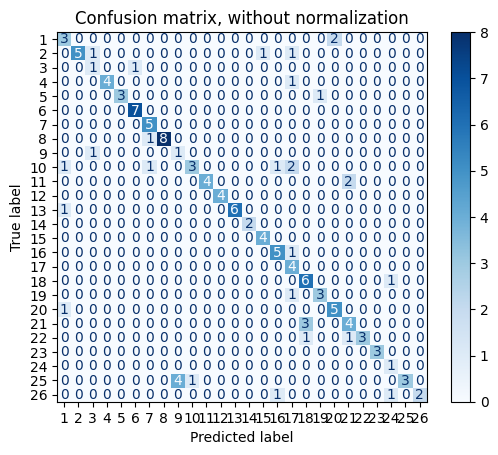

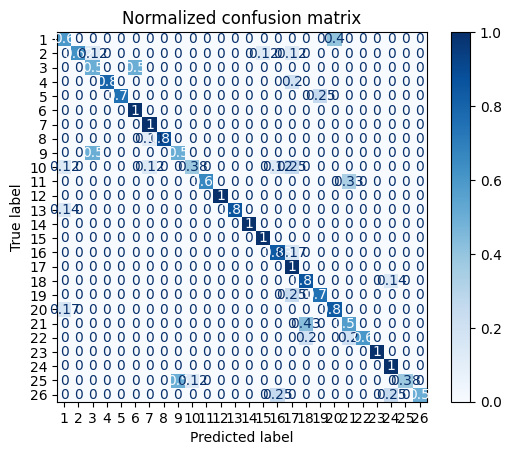

In [42]:
# train a randomforest
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf = RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

print(accuracy_score(rf.predict(X_val), y_val))
print(accuracy_score(rf.predict(X_test), y_test))
print(accuracy_score(rf.predict(X_train), y_train))

print(classification_report(rf.predict(X_val), y_val))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rf,
        X_val,
        y_val,
        display_labels=rf.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
# print(classification_report(rf.predict(X_test), y_test))
# print(classification_report(rf.predict(X_train), y_train))

# ex = ExtraTreesClassifier(random_state=42, n_estimators=100, n_jobs=-1)
# ex.fit(X_train, y_train)


# print(classification_report(ex.predict(X_val), y_val))
# print(classification_report(ex.predict(X_test), y_test))
# print(classification_report(ex.predict(X_train), y_train))

In [43]:
svc = SVC(random_state=42, class_weight="balanced", probability=True)
svc.fit(X_train, y_train)

print(accuracy_score(svc.predict(X_val), y_val))
print(accuracy_score(svc.predict(X_test), y_test))
print(accuracy_score(svc.predict(X_train), y_train))

print(classification_report(svc.predict(X_val), y_val))
# print(classification_report(svc.predict(X_test), y_test))
# print(classification_report(svc.predict(X_train), y_train))

0.8195488721804511
0.8524590163934426
0.9832050279665604
              precision    recall  f1-score   support

           1       1.00      0.62      0.77         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         2
           4       0.60      1.00      0.75         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         9
           9       0.50      0.33      0.40         3
          10       0.62      0.62      0.62         8
          11       0.67      1.00      0.80         4
          12       1.00      1.00      1.00         4
          13       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         2
          15       0.75      1.00      0.86         3
          16       0.83      0.83      0.83         6
          17       1.00 

In [44]:
# save the models
import pickle as pkl
with open("rf_model_moredata.pkl", "wb") as f:
    pkl.dump(rf, f)
with open("svc_model_moredata.pkl", "wb") as f:
    pkl.dump(svc, f)

In [45]:
rf.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [46]:
svc.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])